<a href="https://colab.research.google.com/github/jmarrietar/ocular/blob/inceptionv3/Notebooks/transfer_learning_fine_tunning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import zipfile
import itertools
import numpy as np
from sklearn import metrics
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from mlxtend.plotting import plot_confusion_matrix 
%matplotlib inline

import tensorflow as tf
import keras
import keras_preprocessing
from keras_preprocessing import image
from keras_preprocessing.image import ImageDataGenerator

from keras.applications.vgg16 import VGG16
from keras.applications.resnet50 import ResNet50
from keras.applications import InceptionV3 
from keras import backend as K
from keras.callbacks import Callback, EarlyStopping, ModelCheckpoint
from keras.layers import (
    Dense,
    GlobalAveragePooling2D,
    GlobalMaxPool1D,
    MaxPooling2D,
    Conv2D,
    BatchNormalization,
    Flatten,
    Dropout,
    Concatenate,
    Activation,
    Bidirectional,
)

from keras.layers.recurrent import LSTM
from keras.layers.embeddings import Embedding
from keras.models import Model, Sequential, model_from_json
from keras_preprocessing.image import ImageDataGenerator
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score

Using TensorFlow backend.


In [2]:
#!gdown https://drive.google.com/uc?id=1ysmhUNNwFoGr23F_YbVbbBCziPCfIUS3

In [3]:
#!gdown https://drive.google.com/uc?id=1AnsT5cPD86Iza_bxCQhvqhYz5LAQM_WK

In [6]:
!gdown https://drive.google.com/uc?id=1FcMb77lSumJVART5kgCUm2rXgPILuL5j

Downloading...
From: https://drive.google.com/uc?id=1FcMb77lSumJVART5kgCUm2rXgPILuL5j
To: /content/kaggle_processed_sample.zip
108MB [00:00, 210MB/s]  


In [7]:
!gdown https://drive.google.com/uc?id=1Fij91Xl0KV0d3hx3sDnzqEwoZQGKs21L

Downloading...
From: https://drive.google.com/uc?id=1Fij91Xl0KV0d3hx3sDnzqEwoZQGKs21L
To: /content/messidor2_processed.zip
107MB [00:00, 160MB/s] 


In [9]:
#local_zip = '/content/kaggle_sample.zip'
local_zip = '/content/kaggle_processed_sample.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/content/')
zip_ref.close()

In [10]:
#local_zip = '/content/Messidor-2.zip'
local_zip = '/content/messidor2_processed.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/content/')
zip_ref.close()

In [2]:
#dr_dir = os.path.join('/content/kaggle_sample/train/dr')
#no_dr_dir = os.path.join('/content/kaggle_sample/train/no_dr')
dr_dir = os.path.join('/content/kaggle_processed/train/1')
no_dr_dir = os.path.join('/content/kaggle_processed/train/0')

print("Total imagenes de entrenamiento Diabetic Retinopathy:", len(os.listdir(dr_dir)))
print(
    "Total imagenes de entrenamiento Non Diabetic Retinopathy:",
    len(os.listdir(no_dr_dir)),
)

Total imagenes de entrenamiento Diabetic Retinopathy: 1001
Total imagenes de entrenamiento Non Diabetic Retinopathy: 1000


In [3]:
dr_files = os.listdir(dr_dir)
no_dr_files = os.listdir(no_dr_dir)

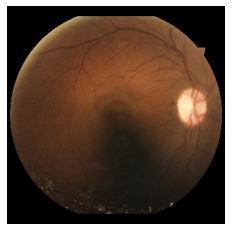

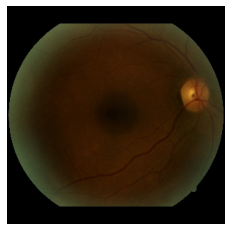

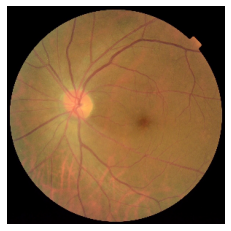

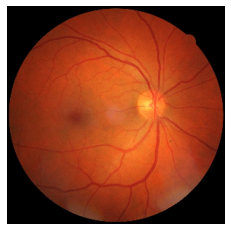

In [4]:
pic_index = 2

next_dr = [os.path.join(dr_dir, fname) for fname in dr_files[pic_index - 2 : pic_index]]
next_no_dr = [
    os.path.join(no_dr_dir, fname) for fname in no_dr_files[pic_index - 2 : pic_index]
]

for i, img_path in enumerate(next_dr + next_no_dr):

    img = mpimg.imread(img_path)
    plt.imshow(img)
    plt.axis("Off")
    plt.show()

In [5]:
#TRAINING_DIR = "/content/kaggle_sample/train"
TRAINING_DIR = "/content/kaggle_processed/train"
#TEST_DIR = "/content/Messidor-2"
TEST_DIR = "/content/messidor2_processed"

BATCH_SIZE = 32
img_width, img_height = 299, 299

training_datagen = ImageDataGenerator(
    rescale=1.0 / 255,
)

train_generator = training_datagen.flow_from_directory(
    TRAINING_DIR,
    target_size=(img_width, img_height),
    class_mode="binary",
    batch_size=BATCH_SIZE,
    shuffle=True,
)

Found 2000 images belonging to 2 classes.


In [6]:
training_datagen2 = ImageDataGenerator(
    rescale=1.0 / 255
)

train_generator2 = training_datagen2.flow_from_directory(
    TRAINING_DIR,
    target_size=(img_width, img_height),
    class_mode="binary",
    batch_size=1,
    shuffle=False,
)

Found 2000 images belonging to 2 classes.


In [25]:
test_datagen = ImageDataGenerator(rescale=1/255)

test_generator = test_datagen.flow_from_directory(
	TEST_DIR,
    target_size=(img_width, img_height),
	class_mode='binary', 
    batch_size=1,
    shuffle=False,
)

Found 1748 images belonging to 2 classes.


In [7]:
steps_per_epoch = train_generator.n // BATCH_SIZE
#validation_steps = img_iter_dev.n // BATCH_SIZE

In [8]:
train_generator.n

2000

In [9]:
BATCH_SIZE

32

In [10]:
steps_per_epoch

62

## 1.2 Fine tunning 

#### Warmup
First we do a warmup training only the top layers:

In [14]:
base_model = InceptionV3(weights='imagenet', 
                   include_top=True,
                   pooling='avg',
                   input_shape=(img_width, img_height,3))

# Freeze the feature extractor (transfer learning)
for layer in base_model.layers:
    layer.trainable=False

base_model = Model(base_model.input, base_model.layers[-2].output) # Remove layers
x4 = BatchNormalization()(base_model.output)
x3 = Dropout(0.5)(x4)
x1 = Dense(512, activation='relu')(x3)
x0 = BatchNormalization()(x1)
x = Dense(1, activation='sigmoid')(x0)

visual_model = Model(inputs=base_model.input, outputs=x)

visual_model.compile(
    loss='binary_crossentropy',
    optimizer=keras.optimizers.RMSprop(lr=1e-3),
    metrics=['accuracy', tf.keras.metrics.AUC()]
)

visual_model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 299, 299, 3)  0                                            
__________________________________________________________________________________________________
conv2d_95 (Conv2D)              (None, 149, 149, 32) 864         input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_95 (BatchNo (None, 149, 149, 32) 96          conv2d_95[0][0]                  
__________________________________________________________________________________________________
activation_95 (Activation)      (None, 149, 149, 32) 0           batch_normalization_95[0][0]     
____________________________________________________________________________________________

In [15]:
visual_model.fit_generator(
    train_generator,
    epochs=50,
    steps_per_epoch=steps_per_epoch
)

Epoch 1/50
62/62 [==============================] - 12s 194ms/step - loss: 0.9982 - accuracy: 0.6179 - auc: 0.6270
Epoch 2/50
62/62 [==============================] - 7s 115ms/step - loss: 0.7131 - accuracy: 0.6900 - auc: 0.6920
Epoch 3/50
62/62 [==============================] - 7s 114ms/step - loss: 0.5832 - accuracy: 0.7185 - auc: 0.7180
Epoch 4/50
62/62 [==============================] - 7s 114ms/step - loss: 0.5239 - accuracy: 0.7363 - auc: 0.7409
Epoch 5/50
62/62 [==============================] - 7s 114ms/step - loss: 0.4798 - accuracy: 0.7724 - auc: 0.7585
Epoch 6/50
62/62 [==============================] - 7s 114ms/step - loss: 0.4629 - accuracy: 0.7744 - auc: 0.7743
Epoch 7/50
62/62 [==============================] - 7s 115ms/step - loss: 0.4537 - accuracy: 0.7724 - auc: 0.7878
Epoch 8/50
62/62 [==============================] - 7s 114ms/step - loss: 0.4486 - accuracy: 0.7927 - auc: 0.7980
Epoch 9/50
62/62 [==============================] - 7s 114ms/step - loss: 0.4081 - accu

#### Unfreeze the extractor layers:
- Allow some of the layers to train with a reduced learning rate  

In [98]:
# Unfreeze the extractor layers
for layer in visual_model.layers[-20:]:
    layer.trainable = True

# change the learning rate
visual_model.compile(
    loss='binary_crossentropy',
    optimizer=keras.optimizers.RMSprop(lr=1e-5),
    metrics=['accuracy', tf.keras.metrics.AUC()]
)

train_generator.reset()

# train
history = visual_model.fit_generator(
    train_generator,
    epochs=20,
    steps_per_epoch=steps_per_epoch
    )

Epoch 1/20
62/62 [==============================] - 10s 164ms/step - loss: 0.1039 - accuracy: 0.9654 - auc_2: 0.9925
Epoch 2/20
62/62 [==============================] - 7s 116ms/step - loss: 0.0926 - accuracy: 0.9675 - auc_2: 0.9946
Epoch 3/20
62/62 [==============================] - 7s 115ms/step - loss: 0.0847 - accuracy: 0.9685 - auc_2: 0.9949
Epoch 4/20
62/62 [==============================] - 7s 115ms/step - loss: 0.0952 - accuracy: 0.9629 - auc_2: 0.9947
Epoch 5/20
62/62 [==============================] - 7s 116ms/step - loss: 0.0807 - accuracy: 0.9726 - auc_2: 0.9951
Epoch 6/20
62/62 [==============================] - 7s 116ms/step - loss: 0.0870 - accuracy: 0.9703 - auc_2: 0.9952
Epoch 7/20
62/62 [==============================] - 7s 115ms/step - loss: 0.0823 - accuracy: 0.9723 - auc_2: 0.9952
Epoch 8/20
62/62 [==============================] - 7s 116ms/step - loss: 0.0761 - accuracy: 0.9748 - auc_2: 0.9955
Epoch 9/20
62/62 [==============================] - 7s 116ms/step - los

#### Metrics on Train

In [101]:
threshold = 0.5
img_iter_val_0, img_iter_val_1 = itertools.tee(train_generator2, 2)
y_true = train_generator2.classes
y_pred_prob_visual = visual_model.predict_generator(train_generator2,verbose=1,workers=0)
y_pred_prob_visual = np.hstack(y_pred_prob_visual)
#y_pred = (y_pred_prob_visual> threshold).astype('int')

2000/2000 [==============================] - 61s 30ms/step


In [102]:
y_pred = (y_pred_prob_visual> threshold).astype('int')

In [103]:
print('Accuracy: {}'.format(accuracy_score(y_true, y_pred)))
print('AUC: {}'.format(roc_auc_score(y_true, y_pred_prob_visual)))

Accuracy: 0.579
AUC: 0.7042550000000001


¿Por que la discrepancia?

#### Metrics on Kaggle test

#### Metrics on Messidor-2

In [33]:
threshold = 0.5
img_iter_val_0, img_iter_val_1 = itertools.tee(test_generator, 2)
y_true = test_generator.classes

In [35]:
y_pred_prob_visual = visual_model.predict_generator(test_generator,verbose=1, workers=5)
y_pred_prob_visual = np.hstack(y_pred_prob_visual)
y_pred = (y_pred_prob_visual> threshold).astype('int')

1748/1748 [==============================] - 47s 27ms/step


### Notes 

In [105]:
fpr, tpr, thresholds = metrics.roc_curve(y_true, y_pred_prob_visual, pos_label=1)
cm=metrics.confusion_matrix(y_true, y_pred)
print('Accuracy: {}'.format(accuracy_score(y_true, y_pred)))
auc = roc_auc_score(y_true, y_pred_prob_visual)
print('AUC: %.3f' % auc)

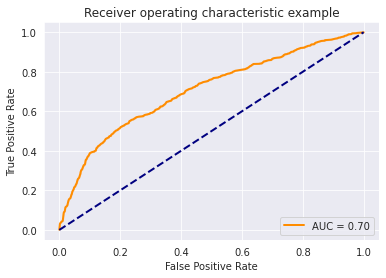

In [107]:
lw = 2
sns.set_style({'axes.grid' : False})
sns.set_style("darkgrid")
ax = sns.lineplot(fpr, tpr, color='darkorange',
         lw=lw, label='AUC = %0.2f' % auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
ax.set_title('Receiver operating characteristic')
ax.set(xlabel='False Positive Rate', ylabel='True Positive Rate')
plt.legend(loc="lower right")
plt.show()

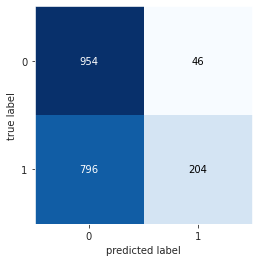

In [123]:
fig, ax = plot_confusion_matrix(conf_mat=cm,
                                show_normed=False)
plt.show()